In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from sklearn import tree, model_selection
from sklearn import tree, ensemble, model_selection, metrics
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from bayes_opt import BayesianOptimization
import seaborn as sns

In C:\Users\PKN\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PKN\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PKN\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\PKN\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PKN\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
Th

### Load all json files

In [3]:
portfolio = pd.read_json('F:/Customer Analytics and Applications/Project/data/portfolio.json', lines = True)
profile = pd.read_json('F:/Customer Analytics and Applications/Project/data/profile.json', lines = True)
transcript = pd.read_json('F:/Customer Analytics and Applications/Project/data/transcript.json', lines = True)

In [4]:
pd.set_option('display.max_columns',50)

### Portfolio data preparation

In [5]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [6]:
portfolio = portfolio.explode('channels')

In [7]:
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['channels'], prefix = 'Is Offer on', prefix_sep = ' ')], axis = 1).drop('channels', axis = 1)

In [8]:
portfolio = portfolio.groupby(['id','reward','difficulty','duration','offer_type'], as_index = False).agg({'Is Offer on email': np.sum,
                                                         'Is Offer on mobile': np.sum,
                                                         'Is Offer on social': np.sum,
                                                         'Is Offer on web': np.sum})

In [9]:
portfolio = portfolio.rename(columns={"id": "offer_id"})

In [10]:
portfolio

,offer_id,reward,difficulty,duration,offer_type,Is Offer on email,Is Offer on mobile,Is Offer on social,Is Offer on web
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1,0,0,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1,1,1,1
2,2906b810c7d4411798c6938adc9daaa5,2,10,7,discount,1,1,0,1
3,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1
4,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,1,1,1
5,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
7,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1
9,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1,1,1,1


### Profile data preparation

In [11]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [12]:
profile.shape

(17000, 5)

In [13]:
profile = profile[~(profile['age']==118)]

In [14]:
profile.shape

(14825, 5)

In [15]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [16]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [17]:
profile = profile.rename(columns={"id": "person"})

In [18]:
profile.head(10)

,gender,age,person,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,20170911,57000.0
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,46000.0
15,F,62,31dda685af34476cad5bc968bdb01c53,20160211,71000.0
16,M,49,62cf5e10845442329191fc246e7bcea3,20141113,52000.0
18,M,57,6445de3b47274c759400cd68131d91b4,20171231,42000.0


### Transcript data preparation

In [19]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [20]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


In [21]:
## Remove offer id and amount from dictionary data type inside value column - Transfer the values to new column

In [22]:
values=[]
for i in transcript['value']:
    values.append(list(i.values())[0])  

In [23]:
transcript['value_new'] = pd.Series()

In [24]:
transcript['value_new'] = values

In [25]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time,value_new
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,9b98b8c7a33c4b65b9aebfe6a799e6d9
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,19.89
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,9b98b8c7a33c4b65b9aebfe6a799e6d9
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,17.78
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,5a8bc65990b245e5a138643cd4eb9837
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,19.67
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,29.72
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,23.93


In [26]:
transcript = transcript.sort_values(['person','time'], ascending = True)

In [27]:
offers = []
for i in transcript['value_new']:
    if type(i)==str:
        offers.append(i)
    else:
        j = offers[-1]
        offers.append(j) 
transcript['offer_id'] = offers 

In [28]:
amounts = []
for i in transcript['value_new']:
    if type(i)==str:
        amounts.append(0)
    else:
        amounts.append(i) 
transcript['transaction_amount'] = amounts 

In [29]:
del transcript['value'], transcript['value_new']

In [30]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,time,offer_id,transaction_amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.78
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.00
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,0.00
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,5a8bc65990b245e5a138643cd4eb9837,19.67
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,5a8bc65990b245e5a138643cd4eb9837,29.72
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,5a8bc65990b245e5a138643cd4eb9837,23.93


In [31]:
transcript_new = pd.concat([transcript, pd.get_dummies(transcript['event'], prefix = 'event', prefix_sep = '_=_')], axis = 1).drop('event', axis = 1)

In [32]:
transcript_new[transcript_new['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,time,offer_id,transaction_amount,event_=_offer completed,event_=_offer received,event_=_offer viewed,event_=_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,1,0,0
15561,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,0,1,0
47582,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89,0,0,0,1
47583,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,1,0,0,0
49502,78afa995795e4d85b5d9ceeca43f5fef,144,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.78,0,0,0,1
53176,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0.00,0,1,0,0
85291,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,0.00,0,0,1,0
87134,78afa995795e4d85b5d9ceeca43f5fef,222,5a8bc65990b245e5a138643cd4eb9837,19.67,0,0,0,1
92104,78afa995795e4d85b5d9ceeca43f5fef,240,5a8bc65990b245e5a138643cd4eb9837,29.72,0,0,0,1
141566,78afa995795e4d85b5d9ceeca43f5fef,378,5a8bc65990b245e5a138643cd4eb9837,23.93,0,0,0,1


In [33]:
transcript_new.columns

Index(['person', 'time', 'offer_id', 'transaction_amount',
       'event_=_offer completed', 'event_=_offer received',
       'event_=_offer viewed', 'event_=_transaction'],
      dtype='object')

In [34]:
transcript_new2 = transcript_new.groupby(['person','offer_id'], as_index = False).agg({'event_=_offer completed': np.sum,
                                                            'event_=_offer received':np.sum,
                                                            'event_=_offer viewed':np.sum})      

In [35]:
transcript_new3 = transcript_new.groupby('person', as_index = False).agg({'transaction_amount': np.sum,
                                                            'event_=_transaction':np.sum}) 

In [36]:
transcript_new2 = pd.DataFrame(transcript_new2)
transcript_new3 = pd.DataFrame(transcript_new3)

In [37]:
transcript_new2.head()

,person,offer_id,event_=_offer completed,event_=_offer received,event_=_offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1


In [38]:
transcript_new2 = transcript_new2.merge(portfolio, on = 'offer_id', how = 'left')

In [39]:
transcript_new2 = pd.concat([transcript_new2,pd.get_dummies(transcript_new2['offer_type'], prefix = 'No. of offers given',  prefix_sep = '_=_')], axis = 1).drop('offer_type', axis = 1)

In [40]:
transcript_new2 = transcript_new2.groupby('person', as_index = False).agg({'event_=_offer completed': np.sum,
                                                                          'event_=_offer received': np.sum,
                                                                          'event_=_offer viewed': np.sum,
                                                                          'reward': np.mean,
                                                                          'difficulty':np.mean,
                                                                          'duration':np.mean,
                                                                          'Is Offer on mobile': np.sum,
                                                                          'Is Offer on social': np.sum,
                                                                          'Is Offer on web': np.sum,
                                                                          'Is Offer on email': np.sum,
                                                                          'No. of offers given_=_bogo':np.sum,
                                                                          'No. of offers given_=_discount': np.sum,
                                                                          'No. of offers given_=_informational':np.sum})

In [41]:
transcript_new2 = transcript_new2.rename(columns = {'Is Offer on mobile':'No of offers given avail on mobile',
                                                   'Is Offer on web':'No of offers given avail on web',
                                                   'Is Offer on social':'No of offers given avail on social',
                                                   'Is Offer on email':'No of offers given avail on email',
                                                   'event_=_offer viewed':'No of offers viewed',
                                                   'difficulty':'Avg offer min spend',
                                                   'duration':'Avg offer duration',
                                                   'reward':'Avg reward pts for offers given'})

In [42]:
transcript_new2.head()

,person,event_=_offer completed,event_=_offer received,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational
0,0009655768c64bdeb2e877511632db8f,3,5,4,1.80,5.00,5.80,5,3,4,5,1,2,2
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,5.00,5.00,5.00,1,1,1,1,1,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,2.60,6.40,6.20,4,2,4,5,1,2,2
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,5.50,7.50,6.25,4,4,2,4,2,1,1
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,3.25,4.25,5.50,4,3,3,4,2,1,1


In [43]:
transcript_new3 = transcript_new3.rename(columns = {'transaction_amount':'Total spend',
                                                   'event_=_transaction':'No of transactions'})

In [44]:
transcript_new3.head()

,person,Total spend,No of transactions
0,0009655768c64bdeb2e877511632db8f,127.60,8
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5
3,0020c2b971eb4e9188eac86d93036a77,196.86,8
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12


In [45]:
transcript_new4 = transcript_new2.merge(transcript_new3, on = 'person', how = 'left')

In [46]:
transcript_new4 = pd.DataFrame(transcript_new4)
transcript_new4.head()

,person,event_=_offer completed,event_=_offer received,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational,Total spend,No of transactions
0,0009655768c64bdeb2e877511632db8f,3,5,4,1.80,5.00,5.80,5,3,4,5,1,2,2,127.60,8
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2,5.00,5.00,5.00,1,1,1,1,1,0,0,4.09,3
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,2.60,6.40,6.20,4,2,4,5,1,2,2,79.46,5
3,0020c2b971eb4e9188eac86d93036a77,3,5,3,5.50,7.50,6.25,4,4,2,4,2,1,1,196.86,8
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,3.25,4.25,5.50,4,3,3,4,2,1,1,154.05,12


In [47]:
transcript_new4[transcript_new4['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event_=_offer completed,event_=_offer received,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational,Total spend,No of transactions
7996,78afa995795e4d85b5d9ceeca43f5fef,3,4,4,5.0,5.0,5.5,4,3,2,4,3,0,1,159.27,7


In [48]:
transcript_new4.shape

(17000, 16)

In [49]:
transcript_new4['event_=_offer completed'].value_counts()

0    4226
2    3202
1    3140
3    3062
4    2201
5     969
6     200
Name: event_=_offer completed, dtype: int64

In [50]:
transcript[(transcript['person']=='073fce5708884b30a28b65b3cb15a919')&(transcript['offer_id']=='9b98b8c7a33c4b65b9aebfe6a799e6d9')]

,person,event,time,offer_id,transaction_amount
2268,073fce5708884b30a28b65b3cb15a919,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
13189,073fce5708884b30a28b65b3cb15a919,offer viewed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
38456,073fce5708884b30a28b65b3cb15a919,transaction,84,9b98b8c7a33c4b65b9aebfe6a799e6d9,25.35
38457,073fce5708884b30a28b65b3cb15a919,offer completed,84,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
45653,073fce5708884b30a28b65b3cb15a919,transaction,120,9b98b8c7a33c4b65b9aebfe6a799e6d9,18.86
50604,073fce5708884b30a28b65b3cb15a919,transaction,150,9b98b8c7a33c4b65b9aebfe6a799e6d9,15.07
55466,073fce5708884b30a28b65b3cb15a919,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
66500,073fce5708884b30a28b65b3cb15a919,offer viewed,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
87449,073fce5708884b30a28b65b3cb15a919,transaction,222,9b98b8c7a33c4b65b9aebfe6a799e6d9,15.21
87450,073fce5708884b30a28b65b3cb15a919,offer completed,222,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00


### Derive usage rate
#### Usage rate = (no of offers completed/no of offers received)*100

In [51]:
transcript_new4['usage_rate'] = (transcript_new4['event_=_offer completed']/transcript_new4['event_=_offer received'])*100

In [52]:
transcript_new4[transcript_new4['event_=_offer completed']==4]

,person,event_=_offer completed,event_=_offer received,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational,Total spend,No of transactions,usage_rate
18,0091d2b6a5ea4defaa8393e4e816db60,4,5,5,6.666667,11.666667,6.666667,2,2,3,3,2,1,0,279.16,12,80.000000
24,00ae03011f9f49b8a4b3e6d416678b0b,4,6,5,3.750000,6.750000,6.000000,4,3,2,4,1,2,1,218.05,8,66.666667
34,00c20a9202d5475190b31a24de6fb06d,4,4,4,5.750000,10.500000,6.750000,3,3,4,4,2,2,0,164.01,8,100.000000
44,00d791e20c564add8056498e40eb56cc,4,5,5,4.600000,5.400000,5.400000,5,4,4,5,3,1,1,59.62,19,80.000000
54,00fac72fd6ad448e8019b175267023df,4,4,4,7.500000,15.000000,8.500000,1,1,1,2,1,1,0,186.23,10,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16972,ff992fbec53145bbae59a68d025e0458,4,6,6,5.000000,7.400000,7.200000,5,4,4,5,3,2,0,73.91,24,66.666667
16974,ff9f73ead16a4f9b9e1a53a27280af92,4,4,3,5.500000,11.250000,7.500000,3,3,4,4,2,2,0,263.30,15,100.000000
16975,ffa81afacde642a3a51a7cd99f8d2cd7,4,5,2,3.333333,8.333333,6.333333,2,1,3,3,1,1,1,275.36,10,80.000000
16977,ffaecba5bbb14cffb04c2490d18eee7e,4,6,5,5.333333,9.166667,7.166667,5,3,5,6,3,2,1,174.33,7,66.666667


In [53]:
transcript_new4.describe()

,event_=_offer completed,event_=_offer received,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational,Total spend,No of transactions,usage_rate
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,16994.000000
mean,1.975235,4.486882,3.395588,4.207543,7.718017,6.507025,3.439824,2.294353,3.059235,3.824765,1.528941,1.532412,0.763412,104.438351,8.173706,43.995234
std,1.605563,1.076165,1.297653,1.527846,2.504153,0.992975,0.997746,0.969232,1.000775,0.965825,0.865295,0.871878,0.663541,125.922619,5.116250,33.939511
min,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.000000,2.750000,3.000000,6.000000,5.800000,3.000000,2.000000,2.000000,3.000000,1.000000,1.000000,0.000000,21.820000,4.000000,16.666667
50%,2.000000,5.000000,3.000000,4.250000,7.500000,6.500000,3.000000,2.000000,3.000000,4.000000,2.000000,2.000000,1.000000,69.405000,7.000000,50.000000
75%,3.000000,5.000000,4.000000,5.000000,9.250000,7.200000,4.000000,3.000000,4.000000,4.000000,2.000000,2.000000,1.000000,148.782500,11.000000,75.000000
max,6.000000,6.000000,6.000000,10.000000,20.000000,10.000000,6.000000,6.000000,6.000000,6.000000,4.000000,4.000000,2.000000,1608.690000,36.000000,100.000000


In [54]:
transcript_new4 = transcript_new4[~transcript_new4['usage_rate'].isna()==True]

In [55]:
transcript_new4.shape

(16994, 17)

In [56]:
transcript_new4['usage_rate'].value_counts()

0.000000      4220
100.000000    1916
50.000000     1736
66.666667     1113
80.000000     1109
75.000000     1100
60.000000     1094
33.333333     1016
40.000000      975
25.000000      947
20.000000      916
83.333333      437
16.666667      415
Name: usage_rate, dtype: int64

### Merge all datasets into one and create target variable - Usage class:
#### 0%usage rate - Class 0 - No use category(will not use the offer at all)
#### Between 0-100%usage rate - Class 1 - Fickle minded category(will use the offer sometimes)
#### 100%usage rate - Class 2 - Sureshot users category(will use the given offer everytime)

In [57]:
df = transcript_new4.merge(profile, on = 'person',how = 'inner')

In [58]:
df.head(10)

,person,event_=_offer completed,event_=_offer received,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational,Total spend,No of transactions,usage_rate,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,3,5,4,1.800000,5.000000,5.800000,5,3,4,5,1,2,2,127.60,8,60.000000,M,33,20170421,72000.0
1,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,2.600000,6.400000,6.200000,4,2,4,5,1,2,2,79.46,5,60.000000,O,40,20180109,57000.0
2,0020c2b971eb4e9188eac86d93036a77,3,5,3,5.500000,7.500000,6.250000,4,4,2,4,2,1,1,196.86,8,60.000000,F,59,20160304,90000.0
3,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,3.250000,4.250000,5.500000,4,3,3,4,2,1,1,154.05,12,75.000000,F,24,20161111,60000.0
4,003d66b6608740288d6cc97a6903f4f0,3,5,4,1.750000,7.500000,6.750000,3,2,3,4,0,2,2,48.34,18,60.000000,F,26,20170621,73000.0
5,00426fe3ffde4c6b9cb9ad6d077a13ea,1,5,2,2.250000,10.000000,7.500000,3,2,3,4,0,3,1,68.51,17,20.000000,F,19,20160809,65000.0
6,004b041fbfe44859945daa2c7f79ee64,2,3,2,2.250000,6.250000,6.500000,4,2,4,4,1,2,1,138.36,6,66.666667,F,55,20180508,74000.0
7,004c5799adbf42868b9cff0396190900,5,5,4,5.666667,8.333333,7.333333,3,3,2,3,2,1,0,347.38,12,100.000000,M,54,20160331,99000.0
8,005500a7188546ff8a767329a2f7c76a,1,5,3,5.666667,8.333333,7.000000,3,1,2,3,2,1,0,20.36,4,20.000000,M,56,20171209,47000.0
9,0056df74b63b4298809f0b375a304cf4,3,4,3,3.250000,8.000000,7.000000,3,1,4,4,1,2,1,144.14,5,75.000000,M,54,20160821,91000.0


In [59]:
df['usage_class'] = pd.Series()

In [60]:
usage_class = []
for i in df['usage_rate']:
    if i ==0.0:
        usage_class.append('0')
    elif i ==100.0:
        usage_class.append('2')
    else:
        usage_class.append('1')

In [61]:
df['usage_class'] = usage_class

In [62]:
df.head(10)

,person,event_=_offer completed,event_=_offer received,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational,Total spend,No of transactions,usage_rate,gender,age,became_member_on,income,usage_class
0,0009655768c64bdeb2e877511632db8f,3,5,4,1.800000,5.000000,5.800000,5,3,4,5,1,2,2,127.60,8,60.000000,M,33,20170421,72000.0,1
1,0011e0d4e6b944f998e987f904e8c1e5,3,5,5,2.600000,6.400000,6.200000,4,2,4,5,1,2,2,79.46,5,60.000000,O,40,20180109,57000.0,1
2,0020c2b971eb4e9188eac86d93036a77,3,5,3,5.500000,7.500000,6.250000,4,4,2,4,2,1,1,196.86,8,60.000000,F,59,20160304,90000.0,1
3,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4,3.250000,4.250000,5.500000,4,3,3,4,2,1,1,154.05,12,75.000000,F,24,20161111,60000.0,1
4,003d66b6608740288d6cc97a6903f4f0,3,5,4,1.750000,7.500000,6.750000,3,2,3,4,0,2,2,48.34,18,60.000000,F,26,20170621,73000.0,1
5,00426fe3ffde4c6b9cb9ad6d077a13ea,1,5,2,2.250000,10.000000,7.500000,3,2,3,4,0,3,1,68.51,17,20.000000,F,19,20160809,65000.0,1
6,004b041fbfe44859945daa2c7f79ee64,2,3,2,2.250000,6.250000,6.500000,4,2,4,4,1,2,1,138.36,6,66.666667,F,55,20180508,74000.0,1
7,004c5799adbf42868b9cff0396190900,5,5,4,5.666667,8.333333,7.333333,3,3,2,3,2,1,0,347.38,12,100.000000,M,54,20160331,99000.0,2
8,005500a7188546ff8a767329a2f7c76a,1,5,3,5.666667,8.333333,7.000000,3,1,2,3,2,1,0,20.36,4,20.000000,M,56,20171209,47000.0,1
9,0056df74b63b4298809f0b375a304cf4,3,4,3,3.250000,8.000000,7.000000,3,1,4,4,1,2,1,144.14,5,75.000000,M,54,20160821,91000.0,1


In [63]:
df['usage_class'].unique()

array(['1', '2', '0'], dtype=object)

In [64]:
df['usage_class'].value_counts()

1    10077
0     2834
2     1909
Name: usage_class, dtype: int64

(array([0, 1, 2]), [Text(0, 0, '1'), Text(1, 0, '0'), Text(2, 0, '2')])

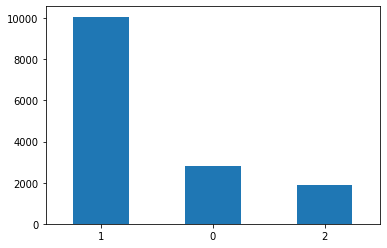

In [65]:
### Distribution of target classes
df['usage_class'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=0)

### Drop columns:
#### Person, offer_id - dropping id columns
#### event_=_offer completed,event_=_offer received,usage_rate - dropped as they were used in creating target variable
#### became_member_on - dropped as join_month is used instead

In [66]:
df = df.drop(['person','event_=_offer completed','event_=_offer received','usage_rate','became_member_on'],axis = 1)

In [67]:
df.head(10)

,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational,Total spend,No of transactions,gender,age,income,usage_class
0,4,1.800000,5.000000,5.800000,5,3,4,5,1,2,2,127.60,8,M,33,72000.0,1
1,5,2.600000,6.400000,6.200000,4,2,4,5,1,2,2,79.46,5,O,40,57000.0,1
2,3,5.500000,7.500000,6.250000,4,4,2,4,2,1,1,196.86,8,F,59,90000.0,1
3,4,3.250000,4.250000,5.500000,4,3,3,4,2,1,1,154.05,12,F,24,60000.0,1
4,4,1.750000,7.500000,6.750000,3,2,3,4,0,2,2,48.34,18,F,26,73000.0,1
5,2,2.250000,10.000000,7.500000,3,2,3,4,0,3,1,68.51,17,F,19,65000.0,1
6,2,2.250000,6.250000,6.500000,4,2,4,4,1,2,1,138.36,6,F,55,74000.0,1
7,4,5.666667,8.333333,7.333333,3,3,2,3,2,1,0,347.38,12,M,54,99000.0,2
8,3,5.666667,8.333333,7.000000,3,1,2,3,2,1,0,20.36,4,M,56,47000.0,1
9,3,3.250000,8.000000,7.000000,3,1,4,4,1,2,1,144.14,5,M,54,91000.0,1


In [68]:
# To do
# Categorical encoding
# Train test split
# Feature scaling
# Hyperparameter tuning
# Model fit and evaluation metrics

### Categorical features encoding for the left out categorical features - offer_type and gender

In [69]:
## For gender
df = pd.concat([df, pd.get_dummies(df['gender'], prefix = 'gender', prefix_sep = '_=_')], axis = 1).drop('gender', axis = 1)

In [70]:
df.head()

,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational,Total spend,No of transactions,age,income,usage_class,gender_=_F,gender_=_M,gender_=_O
0,4,1.80,5.00,5.80,5,3,4,5,1,2,2,127.60,8,33,72000.0,1,0,1,0
1,5,2.60,6.40,6.20,4,2,4,5,1,2,2,79.46,5,40,57000.0,1,0,0,1
2,3,5.50,7.50,6.25,4,4,2,4,2,1,1,196.86,8,59,90000.0,1,1,0,0
3,4,3.25,4.25,5.50,4,3,3,4,2,1,1,154.05,12,24,60000.0,1,1,0,0
4,4,1.75,7.50,6.75,3,2,3,4,0,2,2,48.34,18,26,73000.0,1,1,0,0


In [71]:
df.shape

(14820, 19)

In [72]:
df.describe()

,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational,Total spend,No of transactions,age,income,gender_=_F,gender_=_M,gender_=_O
count,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000,14820.000000
mean,3.364372,4.208978,7.729500,6.512051,3.441768,2.295749,3.062416,3.829015,1.528880,1.536302,0.763833,117.050752,8.362888,54.389069,65406.882591,0.413293,0.572402,0.014305
std,1.290055,1.524678,2.502602,0.989635,0.995799,0.968243,0.998726,0.964542,0.864247,0.872052,0.663785,129.980014,5.182846,17.383172,21598.059614,0.492441,0.494747,0.118749
min,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000
25%,2.000000,3.000000,6.000000,5.800000,3.000000,2.000000,2.000000,3.000000,1.000000,1.000000,0.000000,31.457500,4.000000,42.000000,49000.000000,0.000000,0.000000,0.000000
50%,3.000000,4.250000,7.500000,6.500000,3.000000,2.000000,3.000000,4.000000,2.000000,2.000000,1.000000,87.075000,7.000000,55.000000,64000.000000,0.000000,1.000000,0.000000
75%,4.000000,5.000000,9.250000,7.200000,4.000000,3.000000,4.000000,4.000000,2.000000,2.000000,1.000000,160.972500,11.000000,66.000000,80000.000000,1.000000,1.000000,0.000000
max,6.000000,10.000000,20.000000,10.000000,6.000000,6.000000,6.000000,6.000000,4.000000,4.000000,2.000000,1608.690000,36.000000,101.000000,120000.000000,1.000000,1.000000,1.000000


### Train test split

In [73]:
x = df.drop('usage_class',axis=1)
y = df['usage_class'].astype('int')

In [74]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 1234)

### Feature Scaling

In [75]:
scaler = MinMaxScaler()

In [76]:
x.columns

Index(['No of offers viewed', 'Avg reward pts for offers given',
       'Avg offer min spend', 'Avg offer duration',
       'No of offers given avail on mobile',
       'No of offers given avail on social', 'No of offers given avail on web',
       'No of offers given avail on email', 'No. of offers given_=_bogo',
       'No. of offers given_=_discount', 'No. of offers given_=_informational',
       'Total spend', 'No of transactions', 'age', 'income', 'gender_=_F',
       'gender_=_M', 'gender_=_O'],
      dtype='object')

In [79]:
scaling_features = ['No of offers viewed', 'Avg reward pts for offers given', 'No of offers given avail on mobile',
       'No of offers given avail on social', 'No of offers given avail on web',
       'No of offers given avail on email', 'No. of offers given_=_bogo',
       'No. of offers given_=_discount', 'No. of offers given_=_informational',
       'Total spend', 'No of transactions', 'age', 'income']

In [80]:
x_train[scaling_features] = scaler.fit_transform(x_train[scaling_features])

C:\Users\PKN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PKN\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [81]:
x_test[scaling_features] = scaler.fit_transform(x_test[scaling_features])

C:\Users\PKN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PKN\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [82]:
x_train.shape,x_test.shape

((11856, 18), (2964, 18))

In [83]:
x_train.head()

,No of offers viewed,Avg reward pts for offers given,Avg offer min spend,Avg offer duration,No of offers given avail on mobile,No of offers given avail on social,No of offers given avail on web,No of offers given avail on email,No. of offers given_=_bogo,No. of offers given_=_discount,No. of offers given_=_informational,Total spend,No of transactions,age,income,gender_=_F,gender_=_M,gender_=_O
7792,0.666667,0.460000,5.400000,5.20,0.833333,0.666667,0.500000,0.8,0.50,0.25,1.0,0.033338,0.555556,0.614458,0.188889,0,1,0
5738,0.500000,0.500000,5.000000,5.00,0.333333,0.333333,0.000000,0.2,0.25,0.00,0.5,0.009784,0.111111,0.024096,0.044444,0,1,0
6198,0.500000,0.250000,5.500000,5.75,0.666667,0.333333,0.666667,0.6,0.25,0.50,0.5,0.149451,0.250000,0.493976,0.777778,1,0,0
5317,0.500000,0.500000,5.000000,5.00,0.333333,0.333333,0.000000,0.2,0.25,0.00,0.5,0.014546,0.138889,0.168675,0.322222,0,1,0
11997,0.166667,0.333333,12.333333,9.00,0.333333,0.333333,0.500000,0.4,0.00,0.75,0.0,0.003083,0.083333,0.313253,0.177778,0,1,0


### Hyperparameter tuning

#### Random search

In [109]:
parameters = {'booster': ['gbtree'],'learning_rate' : [0.05,0.06,0.07,0.08,0.09,0.1], 'max_depth':[5,10], 'reg_alpha' :[0,0.01,0.1,1],
             'reg_lambda':[0,0.01,0.1,1], 'n_estimators' : [10,30,50,100,150,200,300], 'colsample_bytree':[0.1,0.3,0.5,0.8,1],
             'min_child_weight':[0.1,0.3,0.5,0.8,1],'subsample':[0.1,0.3,0.5,0.8,1]}

#clf = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1234))
clf = model_selection.RandomizedSearchCV(xgb.XGBClassifier(random_state  = 1234),param_distributions = parameters, cv = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1234), n_iter = 20, scoring = 'accuracy')
clf.fit(x_train, y_train)
print('best parameters: ', clf.best_params_)

best parameters:  {'subsample': 0.5, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.06, 'colsample_bytree': 0.8, 'booster': 'gbtree'}


#### Bayesian Optimization

In [110]:
def xgb_evaluate(**param_range):
    params = {}
    #params['boosting_type'] = 'gbdt'
    params['num_class'] = 3
    params['objective'] = 'multi:softprob'
    params['eval_metric'] = 'mlogloss'
    params['learning_rate']=param_range['learning_rate']
    params['colsample_bytree']=param_range['colsample_bytree']
    params['min_child_weight']=param_range['min_child_weight']
    params['max_depth']=int(round(param_range['max_depth']))
    #params['n_estimators']=int(round(param_range['n_estimators']))
    params['subsample']=param_range['subsample']
    #params['num_boost_round']=int(round(param_range['num_boost_round']))
    #params['min_gain_to_split']=min_gain_to_split
    #lgb_train_data = lgb.Dataset(x_train, label=y_train, free_raw_data = None)
    xgb_train_data = xgb.DMatrix(x_train, label = y_train)
    cv_result = xgb.cv(params,xgb_train_data, num_boost_round = 100, nfold=5, seed=1234,
                       stratified=True,shuffle = True, metrics=('mlogloss')) 
    #print(cv_result)
    return -min(cv_result['test-mlogloss-mean'])

In [111]:
param_range={
'learning_rate':(0.05, 0.15),
'colsample_bytree': (0.1, 1),
'min_child_weight': (0.1, 1),
'max_depth': (5, 10),
'subsample':(0.1, 1),
'reg_alpha':(0,1),
'reg_lambda':(0,1)}

In [112]:
bo = BayesianOptimization(xgb_evaluate, param_range)
bo.maximize(init_points = 5, n_iter = 20, acq = 'ei')

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.3753   |  0.4038   |  0.1166   |  6.893    |  0.7963   |  0.8722   |  0.3344   |  0.735    |
|  2        | -0.382    |  0.2733   |  0.1407   |  5.339    |  0.3555   |  0.8729   |  0.5353   |  0.9253   |
|  3        | -0.3984   |  0.3512   |  0.06091  |  7.773    |  0.8055   |  0.3672   |  0.7401   |  0.7751   |
|  4        | -0.3773   |  0.955    |  0.07386  |  8.595    |  0.6174   |  0.3916   |  0.7993   |  0.8294   |
|  5        | -0.3806   |  0.6125   |  0.05974  |  8.622    |  0.6874   |  0.0248   |  0.3074   |  0.9357   |
|  6        | -0.3823   |  0.3084   |  0.1183   |  5.728    |  0.565    |  0.6459   |  0.1949   |  0.3535   |
|  7        | -0.388    |  0.3147   |  0.1464   |  8.41     |  0.5666   |  0.2365   |  0.2968   |  0.7732   |
|  8      

In [113]:
parameters = bo.max['params']

In [114]:
final_parameters = {}
final_parameters.update({'boosting_type':'gbtree'})
for k, v in parameters.items():
    if k in ['bagging_freq','min_data_in_leaf','max_depth','max_bin','num_leaves']:
        final_parameters[k] = int(round(v))
    else:
        final_parameters[k] = round(v,4)

In [115]:
final_parameters

{'boosting_type': 'gbtree',
 'colsample_bytree': 0.8232,
 'learning_rate': 0.0855,
 'max_depth': 7,
 'min_child_weight': 0.5631,
 'reg_alpha': 0.5777,
 'reg_lambda': 0.0526,
 'subsample': 0.6773}

### Model fitting and obtaining evaluation metrics

In [124]:
extremeboost = xgb.XGBClassifier(booster ='gbtree',
                    subsample=0.5, n_estimators=150, min_child_weight=1, 
                    max_depth=5, colsample_bytree=0.8, learning_rate=0.06, reg_alpha = 0.1, reg_lambda = 1,random_state=1234)
 ### Random search parameters are found to be optimal   

In [125]:
extremeboost.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=1234, reg_alpha=0.1,
              reg_lambda=1, scale_pos_weight=None, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [126]:
y_pred = extremeboost.predict(x_test)

In [127]:
print(metrics.accuracy_score(y_test, y_pred))

0.8427800269905533


In [128]:
extremeboost_report = """
The evaluation report of LightGBM is:
Confusion Matrix:
{}
Accuracy: {}
""".format(metrics.confusion_matrix(y_test, y_pred),
           metrics.accuracy_score(y_test, y_pred))
print(extremeboost_report)
print('The classification report of XGBoost:\n {}'
      .format(metrics.classification_report(y_test, y_pred)))


The evaluation report of LightGBM is:
Confusion Matrix:
[[ 337  226    0]
 [  34 1841  132]
 [   0   74  320]]
Accuracy: 0.8427800269905533

The classification report of XGBoost:
               precision    recall  f1-score   support

           0       0.91      0.60      0.72       563
           1       0.86      0.92      0.89      2007
           2       0.71      0.81      0.76       394

    accuracy                           0.84      2964
   macro avg       0.83      0.78      0.79      2964
weighted avg       0.85      0.84      0.84      2964



In [129]:
extremeboost_prob = extremeboost.predict_proba(x_test)

In [130]:
n_classes = 3

In [131]:
#y_train = label_binarize(y_train, classes=[0, 1, 2])
y_test = label_binarize(y_test, classes=[0, 1, 2])

In [132]:
y_test

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0]])

In [133]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], extremeboost_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), extremeboost_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

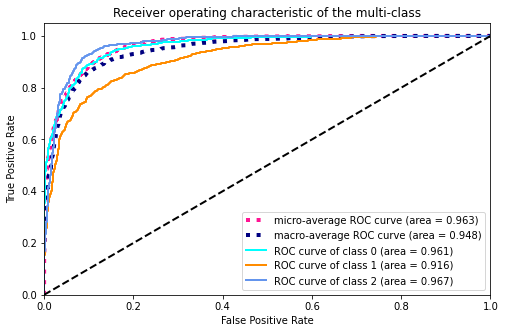

In [136]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.3f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.3f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of the multi-class')
plt.legend(loc="lower right")
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

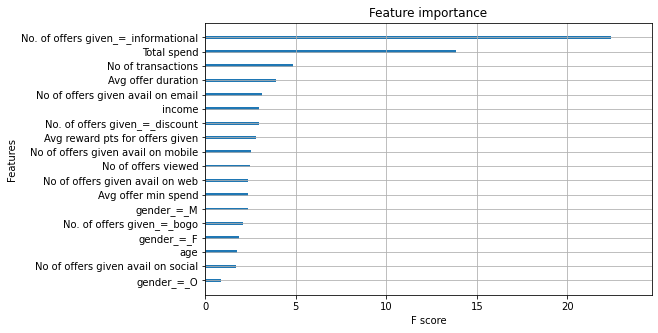

In [135]:
plt.rcParams["figure.figsize"] = (8, 5)
xgb.plot_importance(extremeboost, importance_type='gain',show_values=False)